<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Appendix A: Introduction to PyTorch (Part 2)

## A.9 Optimizing training performance with GPUs

### A.9.1 PyTorch computations on GPU devices

In [1]:
import torch

print(torch.__version__)

2.9.0+cu126


In [2]:
print(torch.cuda.is_available())

True


In [3]:
tensor_1 = torch.tensor([1., 2., 3.])
tensor_2 = torch.tensor([4., 5., 6.])

print(tensor_1 + tensor_2)

tensor([5., 7., 9.])


In [4]:
tensor_1 = tensor_1.to("cuda")
tensor_2 = tensor_2.to("cuda")

print(tensor_1 + tensor_2)

tensor([5., 7., 9.], device='cuda:0')


In [5]:
tensor_1 = tensor_1.to("cpu")
print(tensor_1 + tensor_2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

### A.9.2 Single-GPU training

In [6]:
X_train = torch.tensor([
    [-1.2, 3.1],
    [-0.9, 2.9],
    [-0.5, 2.6],
    [2.3, -1.1],
    [2.7, -1.5]
])

y_train = torch.tensor([0, 0, 0, 1, 1])

X_test = torch.tensor([
    [-0.8, 2.8],
    [2.6, -1.6],
])

y_test = torch.tensor([0, 1])

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [8]:
class ToyDataset(Dataset):
    def __init__(self, X, y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        one_x = self.features[index]
        one_y = self.labels[index]
        return one_x, one_y

    def __len__(self):
        return self.labels.shape[0]

train_ds = ToyDataset(X_train, y_train)
test_ds = ToyDataset(X_test, y_test)

In [ ]:
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=1,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=1
)

In [10]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()

        self.layers = torch.nn.Sequential(

            # 1st hidden layer
            torch.nn.Linear(num_inputs, 30),
            torch.nn.ReLU(),

            # 2nd hidden layer
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20, num_outputs),
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

In [12]:

torch.manual_seed(123)
model = NeuralNetwork(num_inputs=2, num_outputs=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # NEW
model.to(device) # NEW

device

device(type='cuda')

In [13]:

# Note that the book originally used the following line, but the "model =" is redundant
# model = model.to(device) # NEW

optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

num_epochs = 3

for epoch in range(num_epochs):

    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device) # NEW
        logits = model(features)
        loss = F.cross_entropy(logits, labels) # Loss function

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx+1:03d}/{len(train_loader):03d}"
              f" | Train/Val Loss: {loss:.2f}")

    model.eval()
    # Optional model evaluation

Epoch: 001/003 | Batch 001/002 | Train/Val Loss: 0.75
Epoch: 001/003 | Batch 002/002 | Train/Val Loss: 0.65
Epoch: 002/003 | Batch 001/002 | Train/Val Loss: 0.44
Epoch: 002/003 | Batch 002/002 | Train/Val Loss: 0.13
Epoch: 003/003 | Batch 001/002 | Train/Val Loss: 0.03
Epoch: 003/003 | Batch 002/002 | Train/Val Loss: 0.00


In [14]:
def compute_accuracy(model, dataloader, device):

    model = model.eval()
    correct = 0.0
    total_examples = 0

    for idx, (features, labels) in enumerate(dataloader):

        features, labels = features.to(device), labels.to(device) # New

        with torch.no_grad():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)
        compare = labels == predictions
        correct += torch.sum(compare)
        total_examples += len(compare)

    return (correct / total_examples).item()

In [15]:
compute_accuracy(model, train_loader, device=device)

1.0

In [16]:
compute_accuracy(model, test_loader, device=device)

1.0

In [17]:
torch.cuda.device_count()

1

**Exercise A.4**

<small>Compare the run time of matrix multiplication on a CPU to a GPU. At what matrix size do you begin to see the matrix multiplication on the GPU being faster than on the CPU?  
Hint: use the %timeit command in Jupyter to compare the run time.   
For example, given matrices a and b, run the command %timeit a @ b in a new notebook cell.</small>

In [39]:
import timeit

def mm_time(a, b, device):
    t = timeit.timeit(lambda: a.to(device) @ b.to(device), number=100)
    return t / 100

tc = []
tg = []
for d in range(25,702,25):
    a = torch.rand((d,d))
    b = torch.rand((d,d))

    t_cpu = mm_time(a,b,'cpu')
    t_gpu = mm_time(a,b,'cuda')
    tc.append(t_cpu)
    tg.append(t_gpu)

    print('Matrix size:', d)
    print('CPU:', t_cpu)
    print('GPU:', t_gpu)
    print('CPU/GPU ratio:', t_cpu / t_gpu, '\n')


Matrix size: 25
CPU: 1.145704000009573e-05
GPU: 6.210806000126468e-05
CPU/GPU ratio: 0.1844694553309576 

Matrix size: 50
CPU: 9.682350000730367e-06
GPU: 5.6202840000878495e-05
CPU/GPU ratio: 0.17227510212258 

Matrix size: 75
CPU: 2.038404999893828e-05
GPU: 6.32250099988596e-05
CPU/GPU ratio: 0.3224048521195323 

Matrix size: 100
CPU: 3.455403000316437e-05
GPU: 7.57899299969722e-05
CPU/GPU ratio: 0.4559184842174257 

Matrix size: 125
CPU: 6.424428000173065e-05
GPU: 9.089592999771412e-05
CPU/GPU ratio: 0.7067894019385278 

Matrix size: 150
CPU: 0.00010126813000169931
GPU: 0.00010327537000193843
CPU/GPU ratio: 0.9805641945393035 

Matrix size: 175
CPU: 0.0001523068599999533
GPU: 0.00012494007999976021
CPU/GPU ratio: 1.2190392386514048 

Matrix size: 200
CPU: 0.00019210561999898345
GPU: 0.00014746298000318348
CPU/GPU ratio: 1.3027379481605228 

Matrix size: 225
CPU: 0.0002863048600011098
GPU: 0.00017125043000305596
CPU/GPU ratio: 1.6718489991295244 

Matrix size: 250
CPU: 0.0004033666100

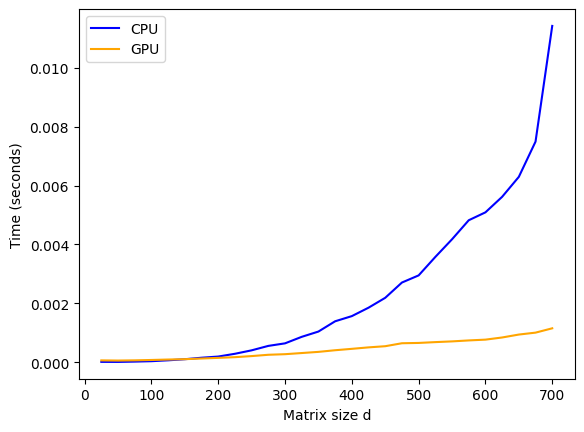

In [40]:

import matplotlib.pyplot as plt

plt.plot(range(25, 702, 25), tc, label="CPU", color="blue")
plt.plot(range(25, 702, 25), tg, label="GPU", color="orange")
plt.xlabel("Matrix size d")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show();

### A.9.3 Training with multiple GPUs

See [DDP-script.py](DDP-script.py)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/appendix-a_compressed/12.webp" width="600px">
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/appendix-a_compressed/13.webp" width="600px">